# Interactive tutorial: extracellular electrical stimulation

## Objectives:
- Understand the concept of ***activating function*** as a predictor of neural excitability
- Understand the impact of various features on neural excitability, namely: 
    - **current polarity and intensity**
    - **electrode-fiber relative positioning**
    - **fiber morphology**
    - **medium properties**
- Understand the *interactions* between artificial electrical stimulation and physiological activity

To better understand these concepts, we will again turn to computational modeling, which consitutes an optimal tool to dissect biophysical interactions. 

## Imports

In [87]:
%load_ext autoreload
%autoreload 2
from fibermodel import MyelinatedFiber
from stimulus import ExtracellularCurrentPulseTrain
from neuronsims import Simulation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Basic model components

We will start by modeling the 3 components interacting in our system of interest, namely:
- **a spatially extended neuron model**
- **an electrically conducting extracellular medium**
- **an stimulation electrode** 

As you have seen during the course, the electrical excitability of neural structures depends on ,multiple factors such as neuronal morphology and the spatial distribution of the induced extracellular potential.

These interactions can be difficult to interpret if we consider the complex (3D) morphology of brain neurons. Therefore, we will leverage here a simplified system, made of a **peripheral axon segment running on a straight line in a nerve**. The morphological and geometrical simplicity of this system allows us better understand stimulus-neuron interactions. 

### Axon model

We are going to use a double-cable, multi-compartment model of a myelinated axon as defined in [McIntyre et al. 2002](https://doi.org/10.1152/jn.00353.2001). Because it incorporates a highly realistic morphology of the spatially distributed neural membrane, this so-called *MRG model* is a consolidated biophysical model used to study the excitability of myelinated axons by electrical fields.

Note that this model is parameterized as a function of axon diameter and number of nodes or Ranvier, such that it can be used to model myelinated axons or arbitrary diameters and lengths.

We will start by defining a "typical" axon of 10 μm diameter and comprising 101 nodes.

In [88]:
diam = 10. # um
nnodes = 101 
fiber = MyelinatedFiber(diam, nnodes=nnodes)
fiber.get_details()

 17/02/2022 16:56:09: initializting model parameters...
 17/02/2022 16:56:09: creating model sections...
 17/02/2022 16:56:09: connecting model sections...
 17/02/2022 16:56:09: defining sections biophysics...
 17/02/2022 16:56:09: created MyelinatedFiber(10.0um) model


,nsec,nseg,diam,L,cm,Ra,xr,xg,xc
node,101.0,1.0,3.3,1.000000,2.0,70.0,337396.911461,1.000000e+10,0.000000
MYSA,200.0,1.0,3.3,3.000000,2.0,70.0,337396.911461,4.166667e-06,0.000417
FLUT,200.0,1.0,6.9,46.000000,2.0,70.0,80683.994905,4.166667e-06,0.000417
STIN,600.0,1.0,6.9,175.166667,2.0,70.0,80683.994905,4.166667e-06,0.000417


## Stimulus model

In [89]:
stim = ExtracellularCurrentPulseTrain(
    pos=(0., 0., 100.),  # um
    I=-10.,  # uA
    tpulse=1.,  # ms
    npulses = 2,
    PRF = 0.2,  # kHz
    tstart=2. # ms
)
stim

ExtracellularCurrentPulseTrain(I=-10.00uA, tpulse=1.0ms, npulses=2, PRF=0.20kHz, tstart=2.0ms)

### First simulation

 17/02/2022 18:41:11: simulating MyelinatedFiber(10.0um) stimulation by ExtracellularCurrentPulseTrain(I=-10.00uA, tpulse=1.0ms, npulses=2, PRF=0.20kHz, tstart=2.0ms)...
 17/02/2022 18:41:12: simulation completed in 0.57 s


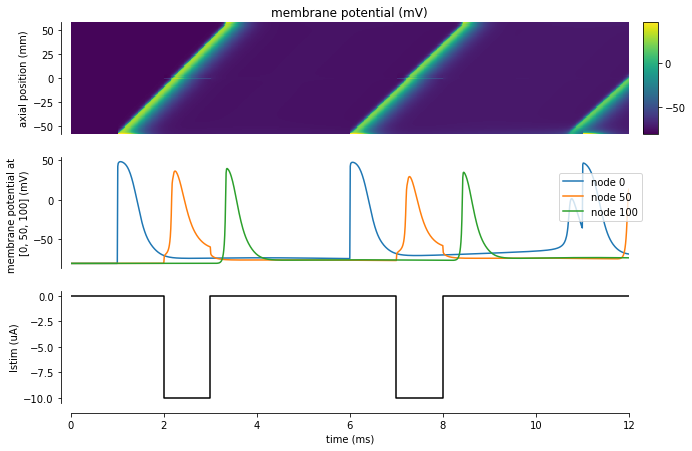

In [101]:
simulation = Simulation(fiber, stim)
simulation.add_presynaptic_input(freq=200.)
tvec, vnodes = simulation.run()
fig = simulation.plot_results(tvec, vnodes)